In [22]:
"""
Main File for QRT - Electricity Price - 2023 Project
"""
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

from scipy.stats import spearmanr

from xgboost import XGBRegressor
from xgboost import plot_importance

from scipy.fft import rfft, rfftfreq, irfft


In [23]:
def plot_ts(ts: pd.Series, title: str = None, figsize=(13,5)) -> None:
    """plots a given timeseries and displays an optional title"""
    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    plt.plot(ts)
    plt.title(title or '', fontsize=10)
    plt.grid(alpha=0.5, linestyle='dashed')
    plt.show()

def metric_train(output, Y_clean):
    return  spearmanr(output, Y_clean).correlation

In [29]:
# Importing Data From Files
curr_dir = '/Users/talhajamal/Desktop/Code/Python_Projects/QRT - 2023 - Electricity Price/'
os.chdir(curr_dir)

X = pd.read_csv(f"{curr_dir}data/X_train_NHkHMNU.csv").set_index('DAY_ID').sort_index()

 # One Hot Encoding for each country
X = pd.get_dummies(X, columns=['COUNTRY'])

y = pd.read_csv(f"{curr_dir}data/y_train_ZAN5mwg.csv").set_index('ID').sort_index()

x_validation = pd.read_csv(f"{curr_dir}data/X_test_final.csv").set_index('ID')
 # One Hot Encoding for each country
x_validation = pd.get_dummies(x_validation, columns=['COUNTRY'])

In [36]:
X

,ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,...,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,COUNTRY_DE,COUNTRY_FR
DAY_ID,,,,,,,,,,,,,,,,,,,,,
0,1057,0.048418,-0.465067,-0.079296,0.079296,NaN,0.650577,NaN,-0.650577,0.592572,...,-0.856204,-0.655528,-1.099226,0.279885,0.583874,-1.071996,-0.074767,0.798003,False,True
1,1179,0.966997,1.222131,0.331356,-0.331356,0.405549,0.778627,-0.405549,-0.778627,1.111008,...,-0.497520,-1.184018,-1.465608,1.349212,0.231602,1.480313,0.931562,0.822047,False,True
2,1327,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,-0.256736,1.228079,...,-0.372156,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434,False,True
2,111,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,-0.256736,1.228079,...,-0.372156,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434,True,False
3,2016,-0.134670,-0.834564,-1.051716,1.051716,-1.881881,-0.612133,1.881881,0.612133,1.588542,...,-1.118297,0.244859,0.488650,-1.710888,-0.951057,0.440121,-0.064550,-0.032756,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1212,1987,-0.046100,-0.520506,-0.270515,0.270515,-0.137917,-0.789824,0.137917,0.789824,0.231723,...,-0.237434,1.358211,1.123953,-0.707839,-0.308232,0.017778,0.072168,-0.160792,False,True
1212,771,-0.046100,-0.520506,-0.270515,0.270515,-0.137917,-0.789824,0.137917,0.789824,0.231723,...,-0.237434,1.358211,1.123953,-0.707839,-0.308232,0.017778,0.072168,-0.160792,True,False
1213,472,1.407027,1.313254,-0.456126,0.456126,0.333142,-0.069222,-0.333142,0.069222,1.781433,...,NaN,NaN,NaN,NaN,NaN,-0.103642,-0.633007,0.214805,True,False


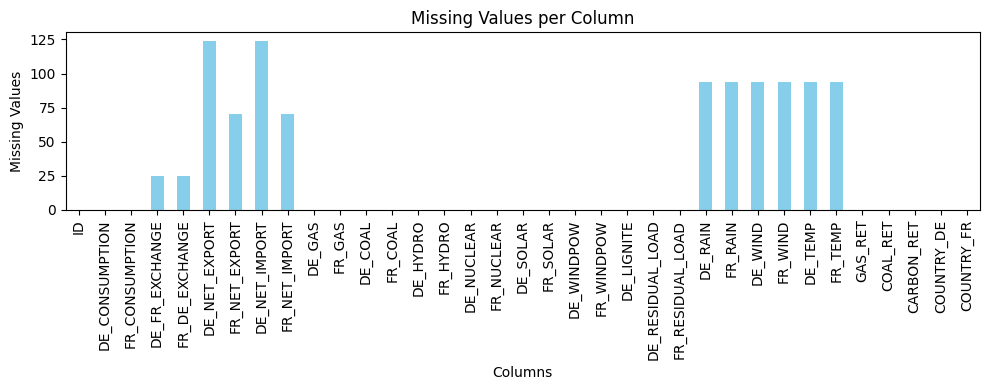

In [38]:
missing_values = X.isna().sum()
missing_values.plot(kind='bar', figsize=(10, 4), color='skyblue')
plt.title('Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Missing Values')
plt.xticks(rotation=90)  # Rotate the x labels to show them vertically
plt.tight_layout()  # Adjust layout to make room for the x labels
plt.show()